1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
0 [D loss: [0.699177 0.515625]] [G loss: [array(0.7166801, dtype=float32), array(0.7166801, dtype=float32), array(0.34375, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

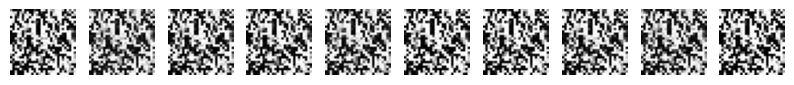

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 152.4023  
Accuracy of model1 on adversarial GAN examples: 0.0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 846.0670  
Accuracy of model2 on adversarial GAN examples: 0.0


In [7]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Загрузка набора данных MNIST
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images[:10000] / 255.0   # Снижено кол-во изображений для более быстрых вычислений в условиях ограниченного времени

# Добавление дополнительного измерения для работы с CNN
train_images = np.expand_dims(train_images, axis=-1)

# Построение генератора
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, activation='relu', input_dim=100))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(784, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

# Построение дискриминатора
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=(28, 28, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Инициализация генератора и дискриминатора
generator = build_generator()
discriminator = build_discriminator()

# Компиляция дискриминатора
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Создание GAN
gan_input = layers.Input(shape=(100,))
generated_image = generator(gan_input)
discriminator.trainable = False
validity = discriminator(generated_image)
gan = tf.keras.Model(gan_input, validity)
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Функция для обучения GAN
def train_gan(generator, discriminator, gan, epochs=200, batch_size=64):  # Снижено кол-во эпох для более быстрых вычислений в условиях ограниченного времени
    half_batch = batch_size // 2
    for epoch in range(epochs):
        # Обучение дискриминатора
        idx = np.random.randint(0, train_images.shape[0], half_batch)
        real_images = train_images[idx]
        noise = np.random.normal(0, 1, (half_batch, 100))
        fake_images = generator.predict(noise)
        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)

        # Обучение генератора через GAN
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_labels)

        if epoch % 100 == 0:
            print(f'{epoch} [D loss: {0.5 * np.add(d_loss_real, d_loss_fake)}] [G loss: {g_loss}]')

# Обучение GAN
train_gan(generator, discriminator, gan)

# Функция генерации противоречивых примеров
def generate_adversarial_examples(generator, n_samples):
    noise = np.random.normal(0, 1, (n_samples, 100))
    generated_images = generator.predict(noise)
    return generated_images

# Генерация 100 примеров
adversarial_images = generate_adversarial_examples(generator, 100)

# Визуализация противоречивых примеров
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(adversarial_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

# Загрузка сохраненных моделей
model1 = tf.keras.models.load_model('/content/sample_data/mlp_mnist.h5')
model2 = tf.keras.models.load_model('/content/sample_data/cnn_mnist.h5')

# Преобразование изображений
adv_images_reshaped = tf.image.resize(adversarial_images, (28, 28))
adv_images_reshaped = adv_images_reshaped.numpy().reshape(-1, 28, 28, 1)

# Оценка первой модели на измененных примерах
loss1, acc1 = model1.evaluate(adv_images_reshaped, np.ones((100, 10)))
print(f'Accuracy of model1 on adversarial GAN examples: {acc1}')

# Оценка второй модели на измененных примерах
loss2, acc2 = model2.evaluate(adv_images_reshaped, np.ones((100, 10)))
print(f'Accuracy of model2 on adversarial GAN examples: {acc2}')



Вывод: в процессе анализа обе модели показали свою неспособность правильно классифицировать противоречивые изображения. Высокие значения потерь и отсутствие правильных предсказаний подтверждают, что модели уязвимы к атакам adversarial-примеров, созданных методом на основе GAN.